In [61]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from utility import CoxPHLoss
from sklearn.preprocessing import StandardScaler
from data_loader import load_veterans_ds, load_cancer_ds, load_aids_ds, load_nhanes_ds # datasets
from data_loader import prepare_veterans_ds, prepare_cancer_ds, \
                        prepare_aids_ds, prepare_nhanes_ds # prepare funcs
from sksurv.linear_model.coxph import BreslowEstimator
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from model_builder import make_vi_model

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Create model instance
model = make_vi_model(n_train_samples=X_train.shape[0],
                      input_shape=X_train.shape[1:],
                      output_dim=1) # set to 1 to only get epistemic uncertainty

# Restore the weights
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
model.load_weights(f'{root_dir}/models/vi/')

optimizer = tf.keras.optimizers.Adam()
loss_fn = CoxPHLoss()

model.compile(loss=loss_fn, optimizer=optimizer)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.


In [62]:
# Make predictions by sampling from the Gaussian posterior
x_pred = X_test[:3]
for rep in range(5): #Predictions for 5 runs
    print(model.predict(x_pred, verbose=0)[0:3].T)

[[ 0.33958665 -1.7214575  -2.307121  ]]
[[-0.6572808   1.0902758  -0.92396104]]
[[-0.01339656  0.5932728  -0.42349398]]
[[-0.33084095  0.65403974  1.2750127 ]]
[[-0.03661695 -1.2345027  -1.5091839 ]]


In [63]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_flipout_28 (DenseFlip  (None, 20)               360       
 out)                                                            
                                                                 
 dense_flipout_29 (DenseFlip  (None, 50)               2100      
 out)                                                            
                                                                 
 dense_flipout_30 (DenseFlip  (None, 20)               2040      
 out)                                                            
                                                                 
 dense_flipout_31 (DenseFlip  (None, 1)                42        
 out)                                                      

In [64]:
# Sample from the parameters for the post predictive
#from keras.models import Model
#layer_name = 'dense_flipout_23'
#model_params = Model(inputs=model.input,
#                     outputs=model.get_layer(layer_name).output)
#for rep in range(5): #Predictions for 5 runs
#    print(model_params.predict(x_pred, verbose=0)[0:3].T)

In [65]:
x_pred = X_test[:3]
runs = 10
vi_cpd = np.zeros((runs,len(x_pred)))
for i in range(0,runs):
    vi_cpd[i,:] = np.reshape(model.predict(x_pred, verbose=0), len(x_pred))
vi_cpd

array([[ 0.47438461, -1.78311336, -0.04094204],
       [-0.56109107, -1.07131028, -0.23205858],
       [-1.59538066, -0.72105765,  0.3392351 ],
       [-0.56955254,  2.3749032 , -0.1475573 ],
       [-0.36803514,  1.27388227,  1.81273901],
       [ 0.54284   , -0.141019  ,  0.11098298],
       [-1.06008923,  0.32703868,  2.96915936],
       [ 0.4431895 , -0.38670361, -0.51655555],
       [ 0.05916172,  0.70891786,  0.74717104],
       [-0.42629123,  0.71279973,  0.45351219]])

In [66]:
# Train the Brewslow estimator
train_predictions = model.predict(X_train, verbose=0).reshape(-1)
breslow = BreslowEstimator().fit(train_predictions, e_train, t_train)

# Make model predictions
x_sample = X_test
runs = 10
model_vi = np.zeros((runs, len(x_sample)))
for i in range(0, runs):
    model_vi[i,:] = np.reshape(model.predict(x_sample, verbose=0), len(x_sample))
    
# Predict the surv func using Breslow to estimate variance
event_times = breslow.get_survival_function(model_vi[0])[0].x
breslow_surv_times = np.zeros((len(x_sample), runs, len(event_times)))
for i in range(0, runs):
    surv_fns = breslow.get_survival_function(model_vi[i,:])
    for j, surv_fn in enumerate(surv_fns):
        breslow_surv_times[j,i,:] = surv_fn.y

<Figure size 512x384 with 0 Axes>

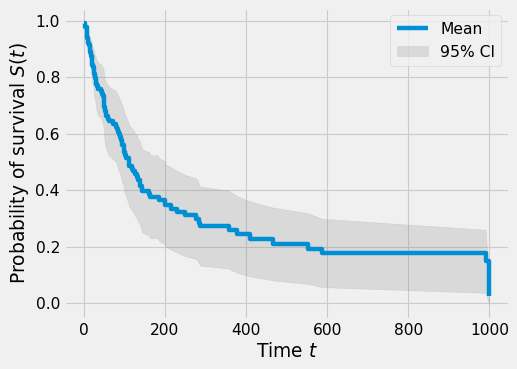

In [67]:
n_samples = breslow_surv_times.shape[1]

plt.figure(dpi=80)

obs_1_surv_times = breslow_surv_times[0,:,:]
ci_surv = 1.96 * np.std(obs_1_surv_times, axis=0) / np.sqrt(n_samples) # 95% CI
mean_surv_times = np.mean(obs_1_surv_times, axis=0)

# Plot surv funcs with mean and CI
plt.figure(dpi=80)
plt.step(event_times, mean_surv_times, where="post", label="Mean")
plt.fill_between(event_times, mean_surv_times-ci_surv, mean_surv_times+ci_surv,
                 color='gray', alpha=0.2, label="95% CI")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.legend()
plt.grid(True)
plt.show()